In [2]:

import jax
import jax.numpy as jnp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Basic import and usage

In [3]:
counters = pd.read_csv('reduced_dataset_sdn.csv')
counters.dt = pd.to_datetime(counters.dt, unit='s')
#counters.set_index('dt', inplace=True)
counters

,dt,switch,src,dst,pktcount,bytecount,dur,dur_nsec,tot_dur,flows,...,pktrate,Pairflow,Protocol,port_no,tx_bytes,rx_bytes,tx_kbps,rx_kbps,tot_kbps,label
0,1970-01-01 03:10:25,1,10.0.0.1,10.0.0.8,45304,48294064,100,716000000,1.010000e+11,3,...,451,0,UDP,3,143928631,3917,0,0,0,0
1,1970-01-01 03:13:25,1,10.0.0.1,10.0.0.8,126395,134737070,280,734000000,2.810000e+11,2,...,451,0,UDP,4,3842,3520,0,0,0,0
2,1970-01-01 03:10:25,1,10.0.0.2,10.0.0.8,90333,96294978,200,744000000,2.010000e+11,3,...,451,0,UDP,1,3795,1242,0,0,0,0
3,1970-01-01 03:10:25,1,10.0.0.2,10.0.0.8,90333,96294978,200,744000000,2.010000e+11,3,...,451,0,UDP,2,3688,1492,0,0,0,0
4,1970-01-01 03:10:25,1,10.0.0.2,10.0.0.8,90333,96294978,200,744000000,2.010000e+11,3,...,451,0,UDP,3,3413,3665,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1970-01-01 03:11:25,4,10.0.0.2,10.0.0.8,117087,124814742,258,834000000,2.590000e+11,6,...,451,0,UDP,2,4139,125201146,0,3837,3837,0
9996,1970-01-01 03:11:25,4,10.0.0.2,10.0.0.8,117087,124814742,258,834000000,2.590000e+11,6,...,451,0,UDP,3,202402181,4127,7676,0,7676,0
9997,1970-01-01 03:11:25,4,10.0.0.13,10.0.0.8,65894,68661548,210,860000000,2.110000e+11,6,...,309,0,UDP,3,4295,238103395,0,10242,10242,1
9998,1970-01-01 03:11:25,4,10.0.0.2,10.0.0.8,117087,124814742,258,834000000,2.590000e+11,6,...,451,0,UDP,1,3795,1402,0,0,0,0


Visualization of UDP Data

## Przygotowanie danych – brakujące dane

Usunięcie całych obserwacji w których występuje brak danych. Często metodę określa się z angielskiego jako complete-case analysis (CCA), czyli analizie poddajemy tylko te obserwacje dla których mamy pełne dane dla wszystkich zmiennych. W naszym przypadku nie posiadamy takich rekordów danych w którym brakowałoby jakichś parametrów.

In [10]:
missing = [var for var in counters.columns if counters[var].isnull().sum() > 0]
missing

[]

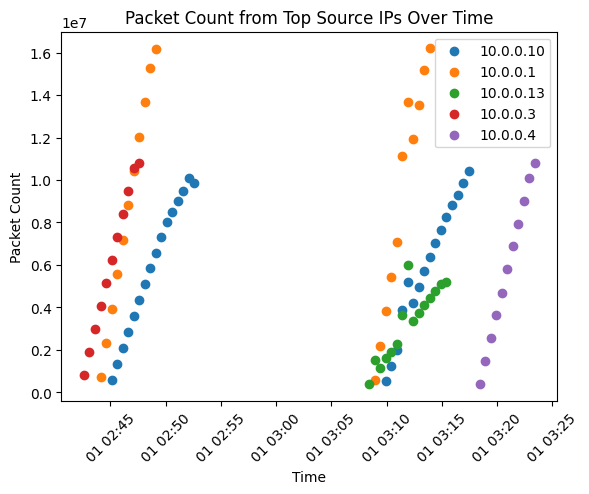

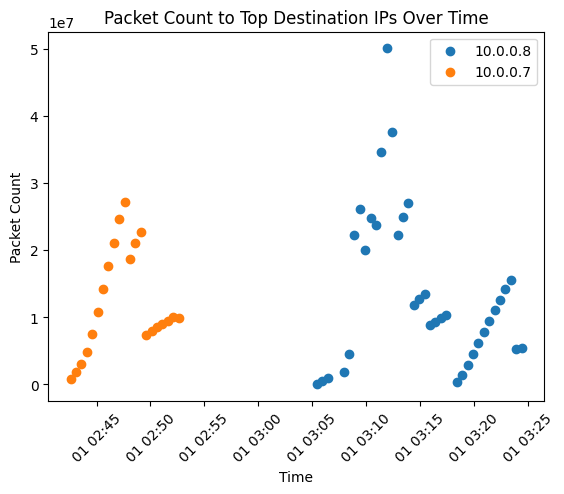

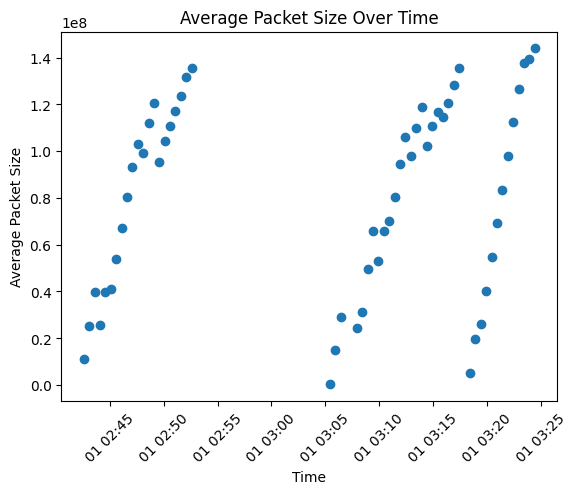

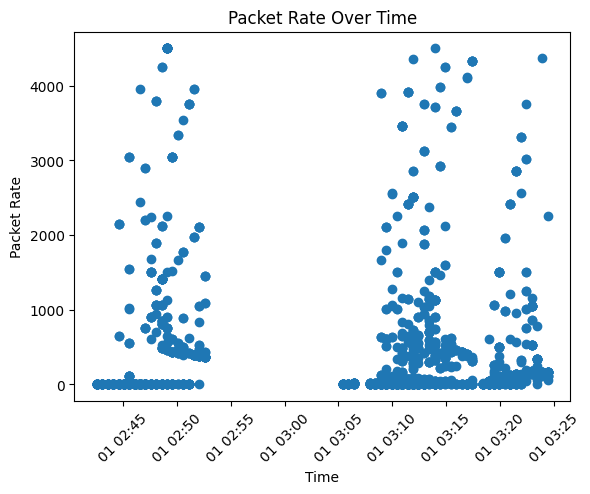

In [7]:
udp_data = counters[counters['Protocol'] == 'UDP']
udp_data['log_bytecount'] = np.log(udp_data['bytecount'] + 1)

# 1. Source IP Count
src_ip_pkt_count = udp_data.groupby(['dt', 'src'])['pktcount'].sum().reset_index()
top_src_ips = src_ip_pkt_count['src'].value_counts().index[:5]
for ip in top_src_ips:
    ip_data = src_ip_pkt_count[src_ip_pkt_count['src'] == ip]
    plt.scatter(ip_data['dt'], ip_data['pktcount'], label=ip)

plt.title('Packet Count from Top Source IPs Over Time')
plt.xlabel('Time')
plt.ylabel('Packet Count')
plt.legend()
plt.xticks(rotation=45)
plt.show()

# 2. Destrination IP Count
dst_ip_pkt_count = udp_data.groupby(['dt', 'dst'])['pktcount'].sum().reset_index()

# Now, let's plot the top 5 destination IPs that received the most packets
top_dst_ips = dst_ip_pkt_count['dst'].value_counts().index[:5]

for ip in top_dst_ips:
    ip_data = dst_ip_pkt_count[dst_ip_pkt_count['dst'] == ip]
    plt.scatter(ip_data['dt'], ip_data['pktcount'], label=ip)

plt.title('Packet Count to Top Destination IPs Over Time')
plt.xlabel('Time')
plt.ylabel('Packet Count')
plt.legend()
plt.xticks(rotation=45)
plt.show()

# 3. Average Packet Size
avg_pkt_size = udp_data.groupby('dt')['bytecount'].mean()
plt.scatter(avg_pkt_size.index, avg_pkt_size)
plt.title('Average Packet Size Over Time')
plt.xlabel('Time')
plt.ylabel('Average Packet Size')
plt.xticks(rotation=45)

plt.show()

# 4. Packet Rate
pkt_rate = udp_data['pktcount'].div(udp_data['dt'].diff().dt.seconds).fillna(0)
plt.scatter(udp_data['dt'], pkt_rate)
plt.title('Packet Rate Over Time')
plt.xlabel('Time')
plt.ylabel('Packet Rate')
plt.xticks(rotation=45)

plt.show()

